<a href="https://colab.research.google.com/github/karsarobert/DeepLearning2024/blob/main/08/PTE_DL8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning gyakorlat


## 8. gyakorlat: konvolúciós hálózat
### 2024. november 06.

In [ ]:
!pip install bing-image-downloader

from bing_image_downloader import downloader

downloader.download("teddy bears", limit=100, output_dir='dataset')
downloader.download("black bears", limit=100, output_dir='dataset')
downloader.download("brown bears", limit=100, output_dir='dataset')


[%] Downloading Images to /content/dataset/teddy bears


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from https://i5.walmartimages.com/asr/8baa3751-0658-4aa5-8b68-89c73841e754_1.119af20f942cfb2e8e9d024424b41dba.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.lifestyle-andmore.de/media/image/b1/d2/e6/1271_0-002cYQ2QJQyiZIJG.jpg
[!] Issue getting: https://www.lifestyle-andmore.de/media/image/b1/d2/e6/1271_0-002cYQ2QJQyiZIJG.jpg
[!] Error:: HTTP Error 404: Not Found
[%] Downloading Image #2 from https://www.sendacuddly.co.uk/wp-content/uploads/2020/08/SendACuddly-1548.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://images.linnlive.com/4ab180c169c2b8195f83403cfd3f26cc/27cfd040-5430-4785-8516-af73cf7adf75.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.vermontteddybear.com/on/demandware.static/-/Sites-master-catalog-vtb/default/dw0c5c4cde/images/VTB/vtb-23846-18ohsosoftteddybear-lightbrown_featu

In [ ]:
 import os
 os.environ['TF_USE_LEGACY_KERAS']='1'

# Ellenőrizzük a GPU-t

In [ ]:
!nvidia-smi

Sun Nov 17 07:50:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install split-folders

#Osszuk fel a fájlokat train és test készletre

In [ ]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("dataset", output="bears",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=True)

Copying files: 0 files [00:00, ? files/s]


#Töltsük be a képeket ImageDataGenerator segítségével

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "bears/train/"
test_dir = "bears/val/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 240 images belonging to 3 classes.
Testing images:
Found 60 images belonging to 3 classes.


#class_names listába töltsük be az osztályok neveit

In [ ]:
import pathlib
import numpy as np
data_dir = pathlib.Path("bears/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Create a list of class_nmaes from the subdirectories
print(class_names)

['black bears' 'brown bears' 'teddy bears']


#töltsük le a efficientnetb0 feature vektor modellt

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    efficientnet_url,
    trainable=False,
    name='feature_extraction_layer',
    input_shape=IMAGE_SHAPE+(3,)
)

In [ ]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

#állítsuk össze a modellt

In [ ]:
# Define the Sequential model
model = tf.keras.Sequential([
    feature_extractor_layer,  # use the feature extraction layer as the base
    layers.Dense(3, activation='softmax', name='output_layer')  # create our own output layer
])

In [ ]:
#!pip install --upgrade tensorflow tensorflow-hub


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4053407 (15.46 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
for layer_number, layer in enumerate(model.layers):
  print(layer_number, layer.name, layer.trainable)

0 feature_extraction_layer False
1 output_layer True


#model.compile, fit

In [ ]:
model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
history = model.fit(train_data, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data))

Epoch 1/10
8/8 [==============================] - 23s 2s/step - loss: 0.8701 - accuracy: 0.6875 - val_loss: 0.5417 - val_accuracy: 0.9667
Epoch 2/10
8/8 [==============================] - 9s 1s/step - loss: 0.4002 - accuracy: 0.9750 - val_loss: 0.2798 - val_accuracy: 1.0000
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 0.2223 - accuracy: 0.9833 - val_loss: 0.1745 - val_accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 9s 1s/step - loss: 0.1455 - accuracy: 0.9833 - val_loss: 0.1263 - val_accuracy: 1.0000
Epoch 5/10
8/8 [==============================] - 8s 1s/step - loss: 0.1064 - accuracy: 0.9833 - val_loss: 0.1000 - val_accuracy: 1.0000
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 0.0841 - accuracy: 0.9917 - val_loss: 0.0842 - val_accuracy: 1.0000
Epoch 7/10
8/8 [==============================] - 9s 1s/step - loss: 0.0711 - accuracy: 0.9917 - val_loss: 0.0732 - val_accuracy: 1.0000
Epoch 8/10
8/8 [======================

#nézzük meg a modell eredményeit

In [ ]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

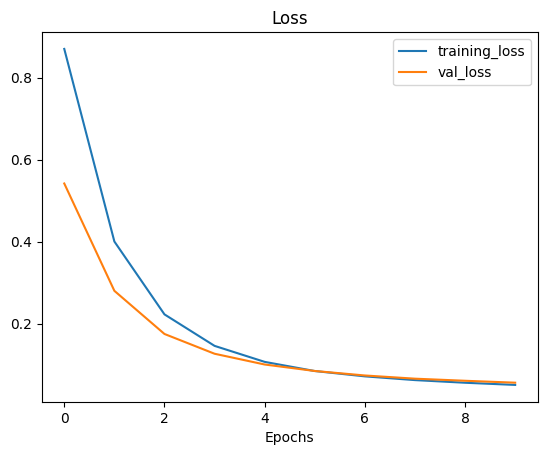

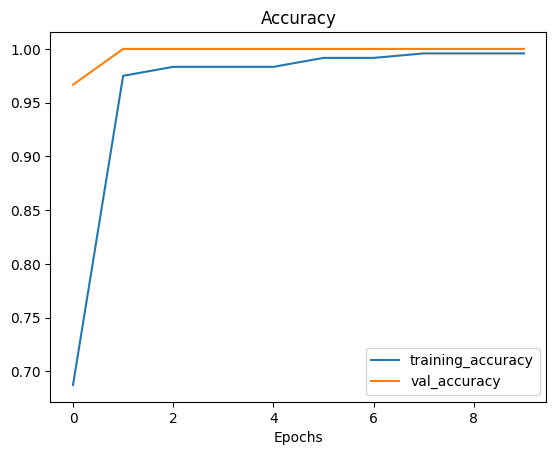

In [ ]:
plot_loss_curves(history)

In [ ]:
model.save('legjobbmodell')

In [ ]:
model2 = tf.keras.models.load_model("legjobbmodell")

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)
    # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3) #tensor formatum
    # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = tf.expand_dims(img, axis=0)
  #img  = img[...,::-1]
  img -= [103, 116, 123]
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
image = load_and_prep_image("teddy.jpg")

In [ ]:
pred = model.predict(image)

1/1 [==============================] - 2s 2s/step


In [ ]:
pred[0]

array([0.02495823, 0.17034727, 0.80469453], dtype=float32)

In [ ]:
np.argmax(pred[0])

2

In [ ]:
pred_class = class_names[np.argmax(pred[0])]
pred_class

'teddy bears'